In [1]:
import numpy as np
import nengo
import nengolib
from nengo_extras.plot_spikes import plot_spikes, preprocess_spikes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Parameters

In [2]:
seed = 0
rng = np.random.RandomState(seed)
n_items = 6
d = 2
n_pre = 200
n_neurons = 100
dt = 0.001
t = 1.0
n_cycles = 10
T = t*n_items*n_cycles
learning_rate = 1e-2
synapse = 0.01

smooth = nengolib.DoubleExp(1e-3, 1e-1)
items = nengolib.stats.ScatteredHypersphere(surface=True).sample(n_items, d, rng=rng)
intercept_mean = (np.dot(items, items.T) - np.eye(n_items)).flatten().max()
intercept_std = 1e-1
intercepts = rng.normal(intercept_mean, intercept_std, n_neurons)
max_rates = nengo.dists.Uniform(200, 400)

### Present inputs in a cyclic pattern, with order randomized every cycle

In [3]:
stim_inpt = np.zeros((int(T/dt)+2, d))
time = 0
for i in range(n_cycles):
    order = np.arange(0, n_items)
    rng.shuffle(order)
    for j in range(n_items):
        for k in range(int(t/dt)):
            stim_inpt[time] = items[order[j]]
            time += 1
stim = lambda x: stim_inpt[int(x/dt)]

# Generate decoders for ```pre```, use VOJA learning rule to sparsify encoders for ```target```, and compute readout decoders for ```target```

In [4]:
with nengo.Network() as network:
    stim_items = nengo.Node(stim)
    
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    
    voja = nengo.Voja(learning_rate=learning_rate, post_synapse=synapse)
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, learning_rule_type=voja)
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_encoders = nengo.Probe(pre_target.learning_rule, "scaled_encoders")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

d_pre = sim.data[pre_target].weights
e_target = sim.data[p_encoders][-1].copy()
a_target = nengolib.Lowpass(synapse).filt(sim.data[p_target], dt=dt)
w_pre_target = np.dot(e_target, d_pre)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

### Confirm encoder learning has worked
Encoders should be clustered around the items defined in Model Parameters

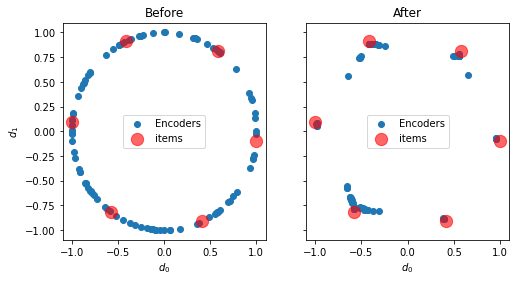

In [6]:
scale = (sim.data[target].gain / target.radius)[:, np.newaxis]
encoders_before = sim.data[p_encoders][0].copy() / scale
encoders_after = sim.data[p_encoders][-1].copy() / scale
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((8, 4)))
ax.scatter(encoders_before[:, 0], encoders_before[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after[:, 0], encoders_after[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(xlabel=r'$d_0$', ylabel=r'$d_1$', title='Before')
ax2.set(xlabel=r'$d_0$', title='After')
ax.legend(loc='best')
ax2.legend(loc='best')

### Remove learning and train decoders for ```target``` (offline)

In [7]:
with nengo.Network() as network:
    stim_items = nengo.Node(stim)
    
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

### Confirm sparse representation can recover estimate of items

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

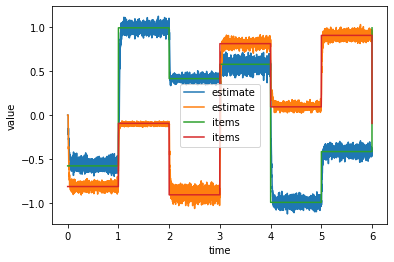

In [8]:
a_target = nengolib.Lowpass(synapse).filt(sim.data[p_target], dt=dt)
d_target = nengo.solvers.LstsqL2(reg=1e-2)(a_target, sim.data[p_items])[0]
estimate = np.dot(a_target, d_target)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_items], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

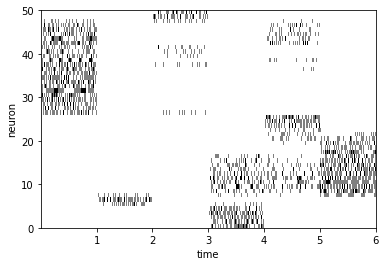

In [9]:
fig, ax = plt.subplots()
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_target]))
ax.set(xlabel='time', ylabel='neuron')

# Define a custom node to implement a connection and a learning rule

In [27]:
class CustomLearningNode(nengo.Node):
    def __init__(self, pre, post, target, d_pre, learning_rate, exc=False, inh=False):
        self.pre = pre
        self.post = post
        self.target = target
        self.size_in = pre.n_neurons + post.n_neurons + target.n_neurons
        self.size_out = post.n_neurons
        self.d_pre = d_pre
        # 'encoders' is a connection-specific matrix used to compute weights; shape (Npre, Npost, d)
        self.e_post = np.zeros((pre.n_neurons, post.n_neurons, d_pre.shape[1]))
        self.weights = np.zeros((pre.n_neurons, post.n_neurons))
        self.learning_rate = learning_rate
        self.exc = exc
        self.inh = inh
        assert self.exc==False or self.inh==False, "Can't force excitatory and inhibitory weights"
        super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)

    def step(self, t, x, update_every=10, dt=1e-3, dAmin=1e0):
        a_pre = x[:self.pre.n_neurons]  # divide inputs to node into corresponding activities
        a_post = x[self.pre.n_neurons: self.pre.n_neurons+self.post.n_neurons]
        a_target = x[self.pre.n_neurons+self.post.n_neurons:]
        if int(t/dt) % update_every == 0: # only update periodically (expensive computation)
            for post in range(self.post.n_neurons):
                dA = a_target[post] - a_post[post]
                if np.abs(dA)<dAmin: continue  # skip update if post activity is close to target activity
                for pre in range(self.pre.n_neurons):
                    for dim in range(self.d_pre.shape[1]): # each dimension of the 'encoder' is updated separately
                        sign = 1.0 if self.d_pre[pre, dim] >= 0 else -1.0 # sign ensures weight change is in the correct direction
                        dE = sign * self.learning_rate * a_pre[pre] # delta for that entry in the encoder matrix
                        self.e_post[pre, post, dim] += dA * dE
                    w = np.dot(self.d_pre[pre], self.e_post[pre, post]) # update corresponding entry in weight matrix
                    if self.exc and w < 0: w = 0 # enforce excitatory weights
                    if self.inh and w > 0: w = 0 # enforce inhibitory weights
                    self.weights[pre, post] = w # update weight matrix
        return np.dot(self.weights.T, a_pre)  # transmit weighted activity from pre to post

# Train the weights on the ```pre-post``` connection so that ```post```'s activities converge to ```target```'s activities

In [28]:
with nengo.Network() as network:
    stim_items = nengo.Node(stim)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7)
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

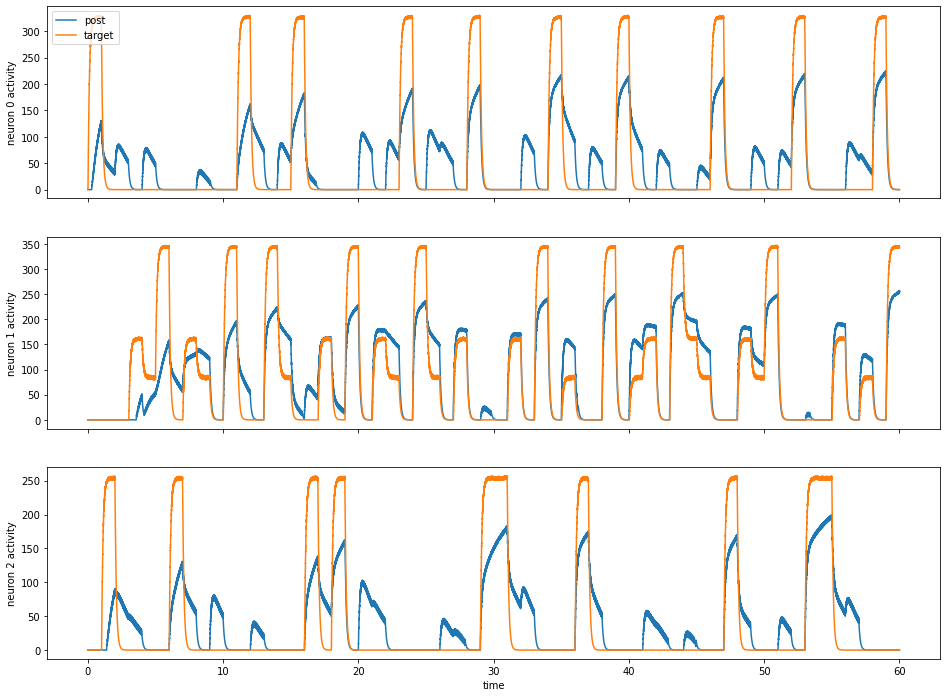

In [29]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

### Simulate again with learning off

In [30]:
w_pre_post = learning_node.weights.copy()

with nengo.Network() as network:
    stim_items = nengo.Node(stim)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))

    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

### Readout items using ```target```'s decoders but ```post```'s activities

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

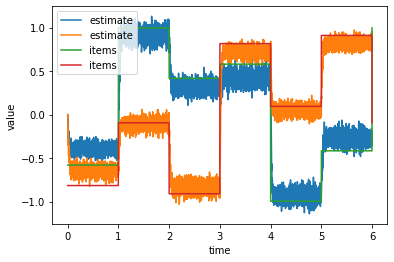

In [31]:
a_post = nengolib.Lowpass(synapse).filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_target)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_items], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

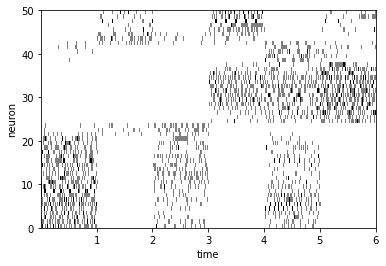

In [32]:
fig, ax = plt.subplots()
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_post]))
ax.set(xlabel='time', ylabel='neuron')

# Excitatory connections only on ```pre-post```

In [33]:
with nengo.Network() as network:
    stim_items = nengo.Node(stim)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7, exc=True)
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=synapse)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)
    
    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

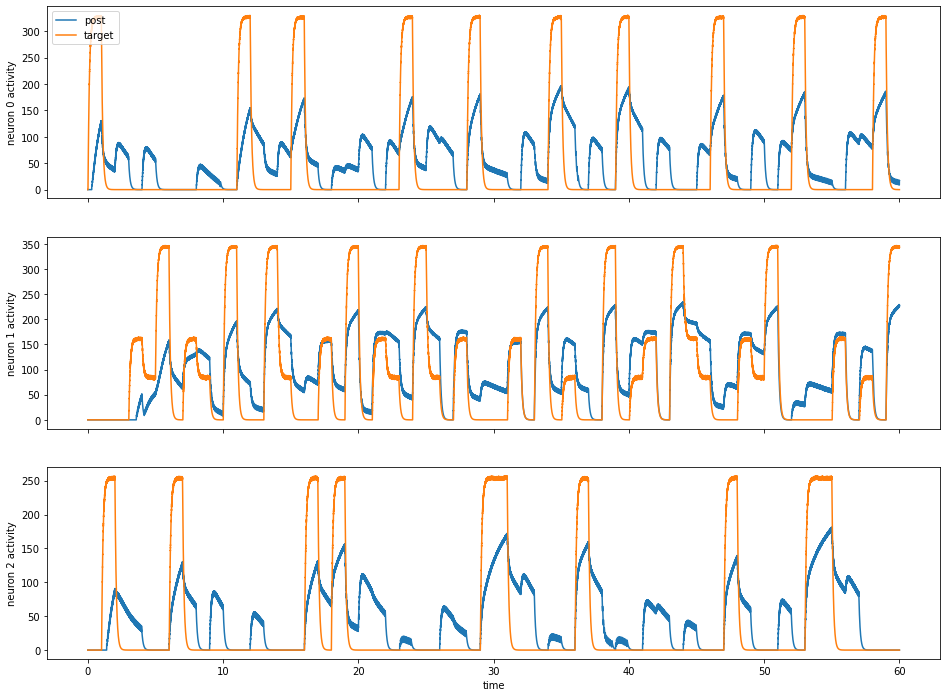

In [34]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

In [35]:
w_pre_post = learning_node.weights.copy()

with nengo.Network() as network:
    stim_items = nengo.Node(stim)

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
        
    stim_pre = nengo.Connection(stim_items, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))

    p_items = nengo.Probe(stim_items, synapse=None)
    p_pre = nengo.Probe(pre.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/ns2dumon/.local/share/virtualenvs/online-sparsity-qVjOxeug/lib/python3.8/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

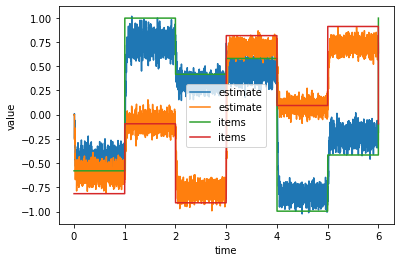

In [36]:
a_post = nengolib.Lowpass(synapse).filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_target)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_items], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

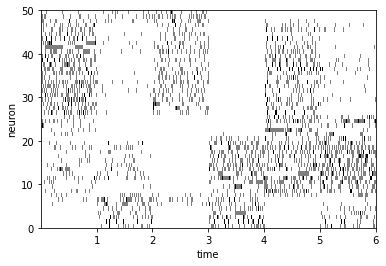

In [37]:
fig, ax = plt.subplots()
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_post]))
ax.set(xlabel='time', ylabel='neuron')